In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import verde as vd
import xarray as xr

# from constrained_linear_regression import ConstrainedLinearRegression
from RIS_gravity_inversion import inversion as inv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
prisms = xr.open_dataset("../synthetic_data/solver_comparison_prisms.nc")

prisms = prisms.reset_coords()

prisms

<xarray.Dataset>
Dimensions:    (northing: 73, easting: 93)
Coordinates:
  * easting    (easting) float64 -6e+03 -5e+03 -4e+03 ... 8.5e+04 8.6e+04
  * northing   (northing) float64 -6e+03 -5e+03 -4e+03 ... 6.5e+04 6.6e+04
Data variables:
    bottom     (northing, easting) float64 ...
    density    (northing, easting) int64 ...
    min_dist   (northing, easting) float64 ...
    thickness  (northing, easting) float64 ...
    top        (northing, easting) float64 ...
    weights    (northing, easting) float64 ...
    surface    (northing, easting) float64 ...
Attributes:
    coords_units:      meters
    properties_units:  SI

In [164]:
prisms_df = vd.grid_to_table(prisms)

buffer_region = vd.get_region((prisms_df.easting, prisms_df.northing))
print(buffer_region)

inversion_region = vd.pad_region(buffer_region, -6e3)
print(inversion_region)
prisms_df

(-6000.0, 86000.0, -6000.0, 66000.0)
(0.0, 80000.0, 0.0, 60000.0)


,northing,easting,bottom,density,min_dist,thickness,top,weights,surface
0,-6000.0,-6000.0,-718.47532,1276,14689.299447,213.657782,-504.817538,1.0,-504.817538
1,-6000.0,-5000.0,-718.47532,1276,14156.041231,203.778093,-514.697227,1.0,-514.697227
2,-6000.0,-4000.0,-718.47532,1276,13675.214383,194.231777,-524.243543,1.0,-524.243543
3,-6000.0,-3000.0,-718.47532,1276,13252.527061,185.026294,-533.449026,1.0,-533.449026
4,-6000.0,-2000.0,-718.47532,1276,12893.698406,176.168074,-542.307245,1.0,-542.307245
...,...,...,...,...,...,...,...,...,...
6784,66000.0,82000.0,-718.47532,1276,22037.402945,81.168242,-637.307078,1.0,-637.307078
6785,66000.0,83000.0,-718.47532,1276,22586.463618,84.962156,-633.513164,1.0,-633.513164
6786,66000.0,84000.0,-718.47532,1276,23165.697678,88.928942,-629.546378,1.0,-629.546378
6787,66000.0,85000.0,-718.47532,1276,23772.899678,93.074038,-625.401282,1.0,-625.401282


# Load Jacobian, residual, and bounds data

In [106]:
# square_jac = np.load("../synthetic_data/square_jacobian.npy")
# square_res = np.load("../synthetic_data/square_residual.npy")

# print(f" Jacobian shape: {np.shape(square_jac)}")
# print(f" Residual shape: {np.shape(square_res)}")

In [110]:
non_square_jac = np.load("../synthetic_data/non_square_jacobian.npy")
non_square_res = np.load("../synthetic_data/non_square_residual.npy")

print(f" Jacobian shape: {np.shape(non_square_jac)}")
print(f" Residual shape: {np.shape(non_square_res)}")

 Jacobian shape: (4941, 6789)
 Residual shape: (4941,)


# Test various solvers

In [111]:
# jacobian = copy.deepcopy(square_jac)
# residuals = copy.deepcopy(square_res)
jacobian = copy.deepcopy(non_square_jac)
residuals = copy.deepcopy(non_square_res)

In [112]:
solvers = [
    "verde least squares",
    "scipy least squares",
    # "scipy constrained",
    # "CLR",
    # "scipy conjugate",
    "numpy least squares",
    # "steepest descent",
    "gauss newton",
]

In [113]:
times = []
results = []
for s in solvers:
    time_start = time.perf_counter()
    step = inv.solver(
        jacobian.copy(),
        residuals,
        solver_type=s,
        bounds=None,
        damping=None,
    )
    time_end = time.perf_counter()
    times.append(time_end - time_start)
    results.append(step)
times

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 6789).
  warn(
/Users/home/tankerma/RIS_gravity_inversion/RIS_gravity_inversion/inversion.py:568: LinAlgWarning: Ill-conditioned matrix (rcond=5.77449e-24): result may not be accurate.
  step = sp.linalg.solve(hessian, gradient)


[15.587397030554712, 5.8780969977378845, 18.35803868342191, 3.3327697021886706]

In [114]:
offset_results = []
for i, r in enumerate(results):
    offset_results.append(r + i * 100)

# import plotly.io as pio
# pio.renderers.default = "notebook"
# pio.renderers
# fig = ff.create_distplot(offset_results, solvers, show_hist=True)
# fig.show()

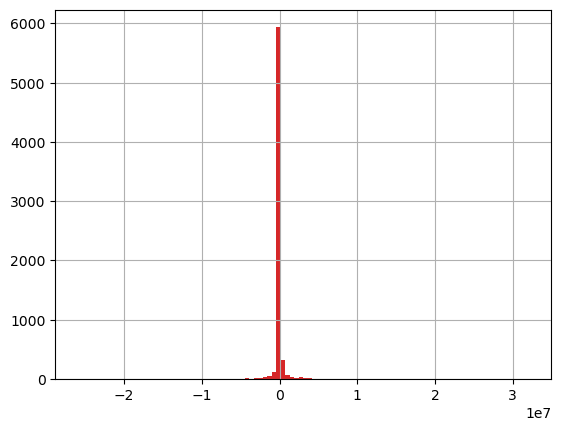

In [115]:
for r in offset_results:
    pd.Series(r).hist(bins=100)

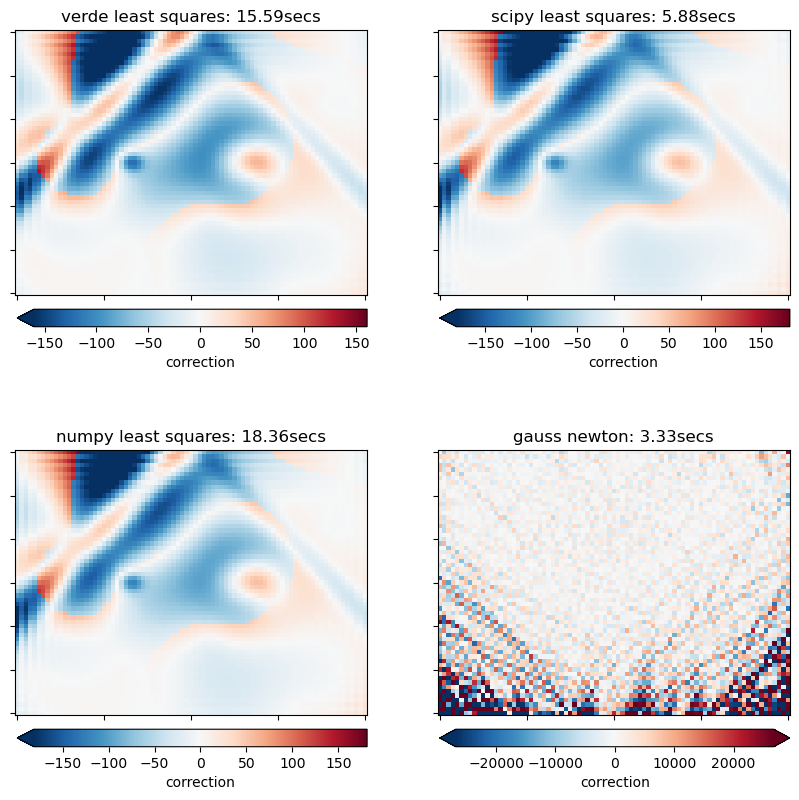

In [117]:
df = prisms_df.copy()

# set figure parameters
sub_width = 5
nrows, ncols = 2, 2

# setup subplot figure
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(sub_width * ncols, sub_width * nrows),
)

g = 0
for i in range(nrows):
    for j in range(ncols):
        df["correction"] = results[g]
        grid = df.set_index(["northing", "easting"]).to_xarray().correction
        grid = grid.sel(
            easting=slice(inversion_region[0], inversion_region[1]),
            northing=slice(inversion_region[2], inversion_region[3]),
        )
        grid.plot(
            ax=ax[i, j],
            robust=True,
            cmap="RdBu_r",
            cbar_kwargs={
                "orientation": "horizontal",
                "anchor": (1, 1),
                "fraction": 0.05,
                "pad": 0.04,
            },
        )
        ax[i, j].set_title(f"{solvers[g]}: {round(times[g],2)}secs")

        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_xlabel("")
        ax[i, j].set_ylabel("")
        ax[i, j].set_aspect("equal")
        g += 1


fig.show()

## with damping

In [127]:
times = []
results = []
for s in solvers:
    time_start = time.perf_counter()
    step = inv.solver(
        jacobian.copy(),
        residuals,
        solver_type=s,
        bounds=None,
        damping=0.1,
        surface=prisms_df.surface,
    )
    time_end = time.perf_counter()
    times.append(time_end - time_start)
    results.append(step)
times

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 6789).
  warn(


[1.2075001867488027,
 0.12579603865742683,
 19.756707618013024,
 4.074487545527518]

In [128]:
offset_results = []
for i, r in enumerate(results):
    offset_results.append(r + i * 100)

# import plotly.io as pio
# pio.renderers.default = "notebook"
# pio.renderers
# fig = ff.create_distplot(offset_results, solvers, show_hist=True)
# fig.show()

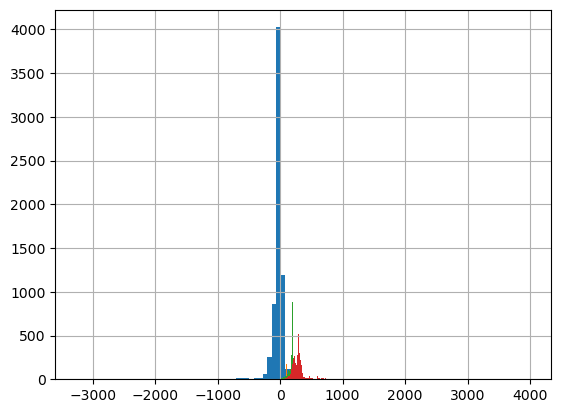

In [129]:
for r in offset_results:
    pd.Series(r).hist(bins=100)

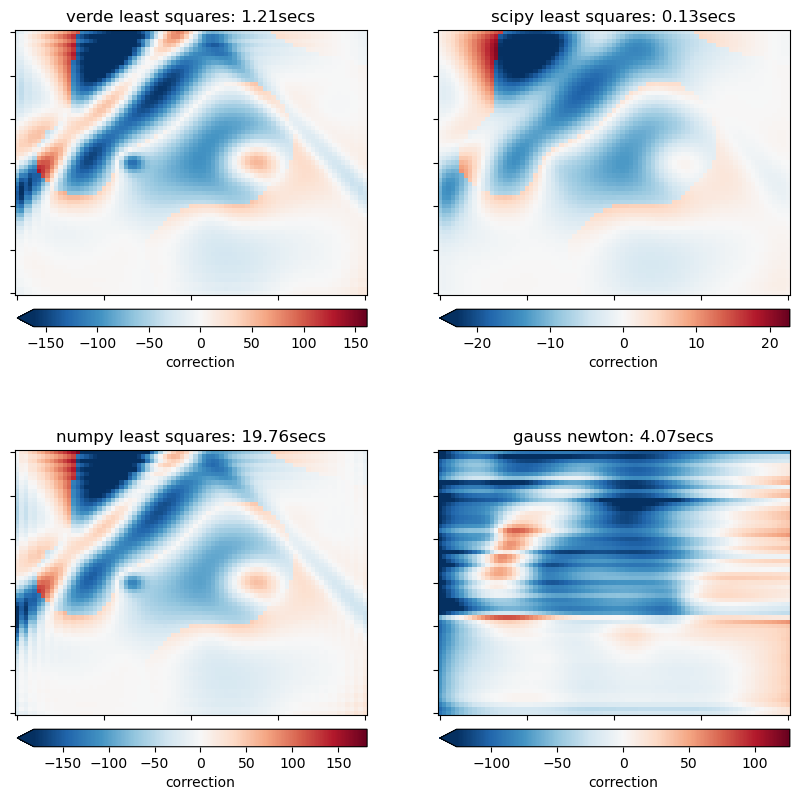

In [130]:
df = prisms_df.copy()

# set figure parameters
sub_width = 5
nrows, ncols = 2, 2

# setup subplot figure
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(sub_width * ncols, sub_width * nrows),
)

g = 0
for i in range(nrows):
    for j in range(ncols):
        df["correction"] = results[g]
        grid = df.set_index(["northing", "easting"]).to_xarray().correction
        grid = grid.sel(
            easting=slice(inversion_region[0], inversion_region[1]),
            northing=slice(inversion_region[2], inversion_region[3]),
        )
        grid.plot(
            ax=ax[i, j],
            robust=True,
            cmap="RdBu_r",
            cbar_kwargs={
                "orientation": "horizontal",
                "anchor": (1, 1),
                "fraction": 0.05,
                "pad": 0.04,
            },
        )
        ax[i, j].set_title(f"{solvers[g]}: {round(times[g],2)}secs")

        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_xlabel("")
        ax[i, j].set_ylabel("")
        ax[i, j].set_aspect("equal")
        g += 1


fig.show()

# Test various solvers with non - square data

In [48]:
jacobian = copy.deepcopy(non_square_jac)
residuals = copy.deepcopy(non_square_res)

In [69]:
solvers = [
    "verde least squares",
    "scipy least squares",
    # "scipy constrained",
    # "CLR",
    # "scipy conjugate",
    "numpy least squares",
    # "steepest descent",
    "gauss newton",
]

In [70]:
times = []
results = []
for s in solvers:
    time_start = time.perf_counter()
    step = inv.solver(
        jacobian.copy(),
        residuals,
        solver_type=s,
        bounds=None,
        damping=None,
    )
    time_end = time.perf_counter()
    times.append(time_end - time_start)
    results.append(step)
times

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/verde/base/least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(4941, 6789).
  warn(
/Users/home/tankerma/RIS_gravity_inversion/RIS_gravity_inversion/inversion.py:568: LinAlgWarning: Ill-conditioned matrix (rcond=5.77449e-24): result may not be accurate.
  step = sp.linalg.solve(hessian, gradient)


[18.175454583019018, 5.90135214291513, 19.06427699327469, 2.378689981997013]

In [71]:
offset_results = []
for i, r in enumerate(results):
    offset_results.append(r + i * 100)

# import plotly.io as pio
# pio.renderers.default = "notebook"
# pio.renderers
# fig = ff.create_distplot(offset_results, solvers, show_hist=True)
# fig.show()

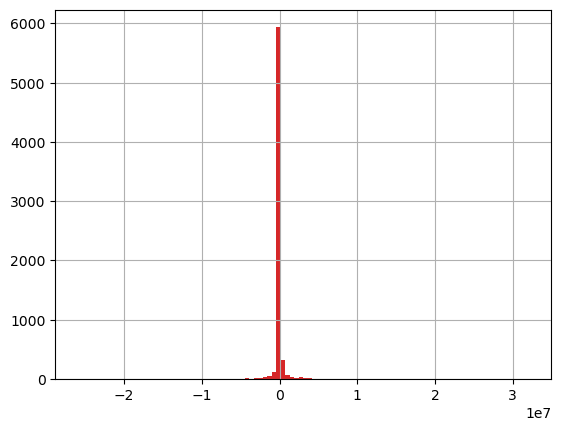

In [72]:
for r in offset_results:
    pd.Series(r).hist(bins=100)

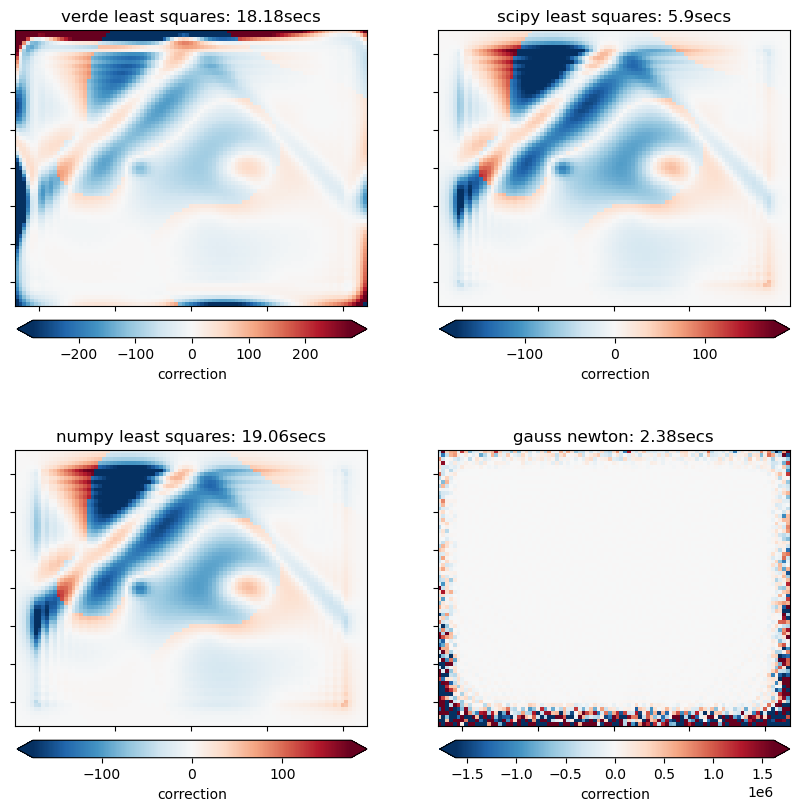

In [73]:
df = prisms_df.copy()

# set figure parameters
sub_width = 5
nrows, ncols = 2, 2

# setup subplot figure
fig, ax = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(sub_width * ncols, sub_width * nrows),
)

g = 0
for i in range(nrows):
    for j in range(ncols):
        df["correction"] = results[g]
        grid = df.set_index(["northing", "easting"]).to_xarray().correction

        grid.plot(
            ax=ax[i, j],
            robust=True,
            cmap="RdBu_r",
            cbar_kwargs={
                "orientation": "horizontal",
                "anchor": (1, 1),
                "fraction": 0.05,
                "pad": 0.04,
            },
        )
        ax[i, j].set_title(f"{solvers[g]}: {round(times[g],2)}secs")

        ax[i, j].set_xticklabels([])
        ax[i, j].set_yticklabels([])
        ax[i, j].set_xlabel("")
        ax[i, j].set_ylabel("")
        ax[i, j].set_aspect("equal")
        g += 1


fig.show()

In [83]:
np.shape(jacobian)

(4941, 6789)

In [165]:
prisms_df

,northing,easting,bottom,density,min_dist,thickness,top,weights,surface
0,-6000.0,-6000.0,-718.47532,1276,14689.299447,213.657782,-504.817538,1.0,-504.817538
1,-6000.0,-5000.0,-718.47532,1276,14156.041231,203.778093,-514.697227,1.0,-514.697227
2,-6000.0,-4000.0,-718.47532,1276,13675.214383,194.231777,-524.243543,1.0,-524.243543
3,-6000.0,-3000.0,-718.47532,1276,13252.527061,185.026294,-533.449026,1.0,-533.449026
4,-6000.0,-2000.0,-718.47532,1276,12893.698406,176.168074,-542.307245,1.0,-542.307245
...,...,...,...,...,...,...,...,...,...
6784,66000.0,82000.0,-718.47532,1276,22037.402945,81.168242,-637.307078,1.0,-637.307078
6785,66000.0,83000.0,-718.47532,1276,22586.463618,84.962156,-633.513164,1.0,-633.513164
6786,66000.0,84000.0,-718.47532,1276,23165.697678,88.928942,-629.546378,1.0,-629.546378
6787,66000.0,85000.0,-718.47532,1276,23772.899678,93.074038,-625.401282,1.0,-625.401282


(6788, 6789)
(6789, 6789)
(6789,)
(4941, 6789)


<Axes: >

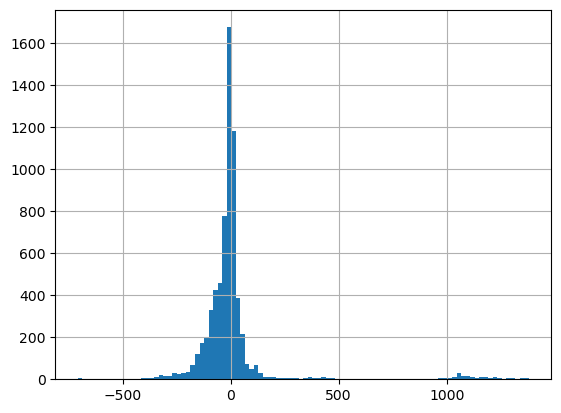

In [166]:
# Gauss Newton w/ 1st order Tikhonov regularization
jacobian = jacobian.copy()

damping = 0.000001

if damping in [None, 0]:
    hessian = jacobian.T @ jacobian
    gradient = jacobian.T @ residuals
else:
    fdmatrix = inv.finite_difference_matrix(len(prisms_df.surface))
    hessian = (jacobian.T @ jacobian) + damping * (fdmatrix.T @ fdmatrix)
    gradient = (jacobian.T @ residuals) - damping * (
        fdmatrix.T @ fdmatrix @ prisms_df.top
    )
    print(np.shape(fdmatrix))
    print(np.shape(hessian))
    print(np.shape(gradient))
    print(np.shape(jacobian))
step = np.linalg.solve(hessian, gradient)
step
pd.Series(step).hist(bins=100)

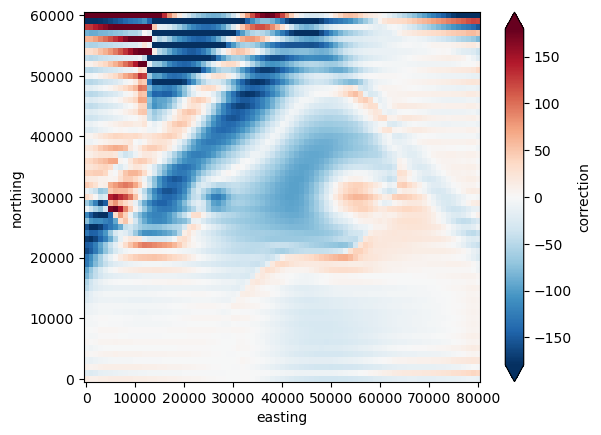

In [167]:
df["correction"] = step
grid = df.set_index(["northing", "easting"]).to_xarray().correction
grid = grid.sel(
    easting=slice(inversion_region[0], inversion_region[1]),
    northing=slice(inversion_region[2], inversion_region[3]),
)
grid.plot(robust=True)